# Toy example

In [1]:
from bhad.utils import (discretize, mvt2mixture)
from bhad.model import BHAD
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [2]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 2*10**4                     # sample size

# Specify first and second moments for each component  
bvt = mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(20000, 30)


In [3]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.01025

In [4]:
# import random

# dataset['cat0'] = np.array(random.choices(['A', 'B', 'C'], k=N))

# minority_class_index = random.choices(range(N), k=100)

# dataset.loc[minority_class_index,'cat0'] = 'Minority'

# dataset.info(verbose=True)

### Visualize the data:

In [5]:
#bvt.show2D(alpha = .45, edgecolor='k', save_plot = False)
#bvt.show3D(alpha = .45, edgecolor='k', save_plot = False)    # plot the first three dimensions

Reduce dimension for visualization only:

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

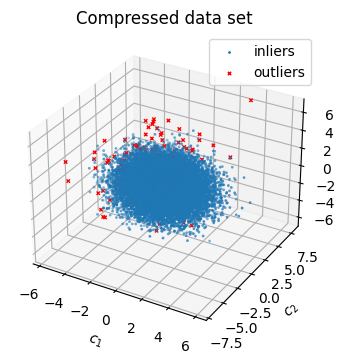

In [25]:
# Plot all the ground truth points together with the predictions
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

Partition dataset:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y_true, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(13400, 30)
(6600, 30)
(array([0, 1]), array([13268,   132]))
(array([0, 1]), array([6527,   73]))


### Model training and prediction

In [9]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete' , discretize(nbins = None, verbose = False)),      # step only needed if continous features are present
    ('model', BHAD(contamination = 0.01))
])

y_pred_train = pipe.fit_predict(X_train)
scores_train = pipe.decision_function(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Finished 'fit' in 4.8119 secs
Finished 'transform' in 0.0215 secs
Fit BHAD on discretized data.
Input shape: (13400, 30)
One-hot encoding categorical features.
Finished 'fit' in 1.1037 secs
Finished 'transform' in 12.5775 secs
Matrix dimension after one-hot encoding: (13400, 861)
Finished training.
Score input data.
Finished 'transform' in 0.0166 secs
Score input data.


In [10]:
y_pred_test = pipe.predict(X_test)
scores_test = pipe.decision_function(X_test)

Finished 'transform' in 36.2690 secs

Score input data.
Apply fitted one-hot encoder.
Finished 'transform' in 6.2537 secs
Finished 'transform' in 36.3382 secs

Score input data.
Apply fitted one-hot encoder.
Finished 'transform' in 6.2095 secs


Plot score distribution:

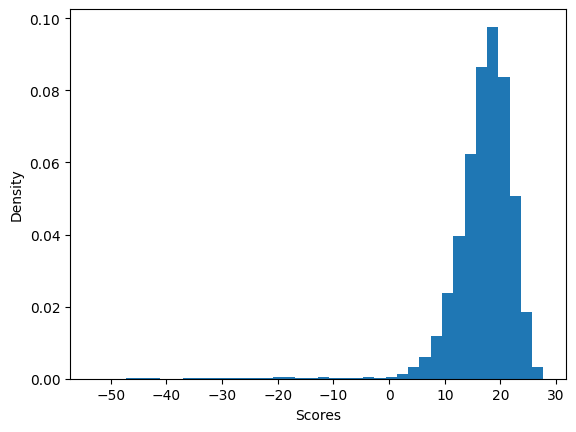

In [11]:
plt.hist(scores_train, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

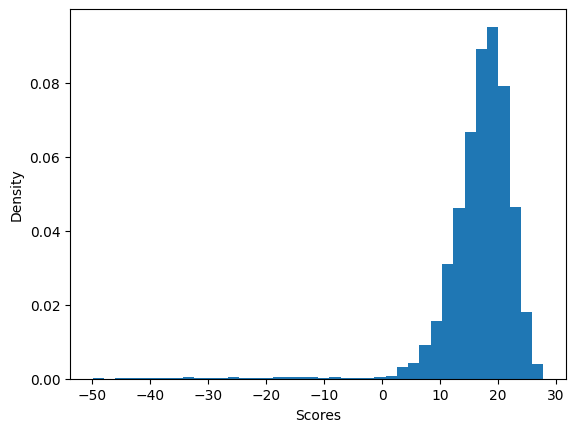

In [12]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [13]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     13268
     Outlier       0.95      0.96      0.95       132

    accuracy                           1.00     13400
   macro avg       0.97      0.98      0.98     13400
weighted avg       1.00      1.00      1.00     13400



In [14]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      6527
     Outlier       0.92      0.99      0.95        73

    accuracy                           1.00      6600
   macro avg       0.96      0.99      0.98      6600
weighted avg       1.00      1.00      1.00      6600



In [15]:
# num = list(dataset.columns)
# num.remove('cat0')
# categ = ['cat0']

## Model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [15]:
numeric_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

print(len(cat_cols+numeric_cols))

30


In [16]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete' , discretize(nbins = None, verbose = True)),     
    ('model', BHAD(contamination = 0.01, numeric_features = numeric_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Input shape: (13400, 30)
Used 30 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature var0 using 34 bins
Determining optimal number of bins for numeric features
Feature var1 using 37 bins
Determining optimal number of bins for numeric features
Feature var2 using 37 bins
Determining optimal number of bins for numeric features
Feature var3 using 41 bins
Determining optimal number of bins for numeric features
Feature var4 using 36 bins
Determining optimal number of bins for numeric features
Feature var5 using 36 bins
Determining optimal number of bins for numeric features
Feature var6 using 31 bins
Determining optimal number of bins for numeric features
Feature var7 using 37 bins
Determining optimal number of bins for numeric features
Feature var8 using 41 bins
Determining optimal number of bins for numeric features
Feature var9 using 41 bins
Determining optimal number of b

In [17]:
from bhad import explainer

reload(explainer)

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and fitted discretizer.
Marginal cdfs estimated using train set of shape (13400, 30)


In [18]:
df_train = local_expl.get_explanation()

Create local explanations for 13400 observations.


  0%|          | 0/13400 [00:00<?, ?it/s]

Finished 'get_explanation' in 4.2118 secs


(13400, 31)

In [19]:
for obs, ex in enumerate(df_train.explanation.values):
    if (obs % 5000) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 var28 (Cumul.perc.: 0.01): -7.09
var0 (Cumul.perc.: 0.97): 6.65
var18 (Cumul.perc.: 0.05): -4.77
var7 (Cumul.perc.: 0.95): 5.19
var21 (Cumul.perc.: 0.05): -4.85

Obs. 5000:
 var3 (Cumul.perc.: 0.99): 7.05
var29 (Cumul.perc.: 0.98): 7.12
var20 (Cumul.perc.: 0.96): 5.1
var4 (Cumul.perc.: 0.95): 5.46
var17 (Cumul.perc.: 0.95): 5.42

Obs. 10000:
 var16 (Cumul.perc.: 0.0): -6.86
var15 (Cumul.perc.: 0.92): 4.5
var28 (Cumul.perc.: 0.14): -2.67
var21 (Cumul.perc.: 0.81): 3.43
var22 (Cumul.perc.: 0.16): -2.43


In [20]:
y_pred_test = pipe.predict(X_test)

Finished 'transform' in 36.4112 secs

Score input data.
Apply fitted one-hot encoder.
Finished 'transform' in 6.2197 secs


(6600, 30)

In [21]:
df_test, _ = local_expl.get_explanation()

Create local explanations for 6600 observations.


  0%|          | 0/6600 [00:00<?, ?it/s]

Finished 'get_explanation' in 1.9904 secs


(6600, 31)